In [1]:
!pip install efficientnet

In [2]:
#import the libraries needed 

import pandas as pd
import numpy as np

import os
import cv2

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import efficientnet.tfkeras as efn

import warnings
warnings.filterwarnings("ignore")

In [3]:
current_path = r'C:\Users\nguyent2\Desktop\Kaggle-Four-Shapes-Classification-Challenge\Kaggle Dataset\shapes'
circle_paths = os.listdir(os.path.join(current_path, 'circle'))
square_paths = os.listdir(os.path.join(current_path, 'square'))
star_paths = os.listdir(os.path.join(current_path, 'star'))
triangle_paths = os.listdir(os.path.join(current_path, 'triangle'))

In [4]:
print(f'We got {len(circle_paths)} circles, {len(square_paths)} squares, {len(star_paths)} stars, and {len(triangle_paths)} triangles' )

We got 3720 circles, 3765 squares, 3765 stars, and 3720 triangles


In [5]:
circles = pd.DataFrame()
squares = pd.DataFrame()
stars = pd.DataFrame()
triangles = pd.DataFrame()

for n,i in enumerate(tqdm(range(len(circle_paths)))):
    circle_path = os.path.join(current_path, 'circle' ,circle_paths[i])
    circles.loc[n,'path'] = circle_path
    circles.loc[n, 'circle'] = 1
    circles.loc[n, 'square'] = 2
    circles.loc[n, 'star'] = 3  
    circles.loc[n, 'triangle'] = 0

for n,i in enumerate(tqdm(range(len(square_paths)))):
    square_path = os.path.join(current_path, 'square' ,square_paths[i])
    squares.loc[n,'path'] = square_path
    squares.loc[n, 'circle'] = 0
    squares.loc[n, 'square'] = 1 
    squares.loc[n, 'star'] = 2   
    squares.loc[n, 'triangle'] = 3
    
for n,i in enumerate(tqdm(range(len(star_paths)))):
    star_path = os.path.join(current_path, 'star' ,star_paths[i])
    stars.loc[n,'path'] = star_path
    stars.loc[n, 'circle'] = 3
    stars.loc[n, 'square'] = 0
    stars.loc[n, 'star'] = 1   
    stars.loc[n, 'triangle'] = 2
    
for n,i in enumerate(tqdm(range(len(triangle_paths)))):
    triangle_path = os.path.join(current_path, 'triangle' ,triangle_paths[i])
    triangles.loc[n,'path'] = triangle_path
    triangles.loc[n, 'circle'] = 2
    triangles.loc[n, 'square'] = 3 
    triangles.loc[n, 'star'] = 0   
    triangles.loc[n, 'triangle'] = 1
    
data = pd.concat([circles, squares, stars, triangles], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

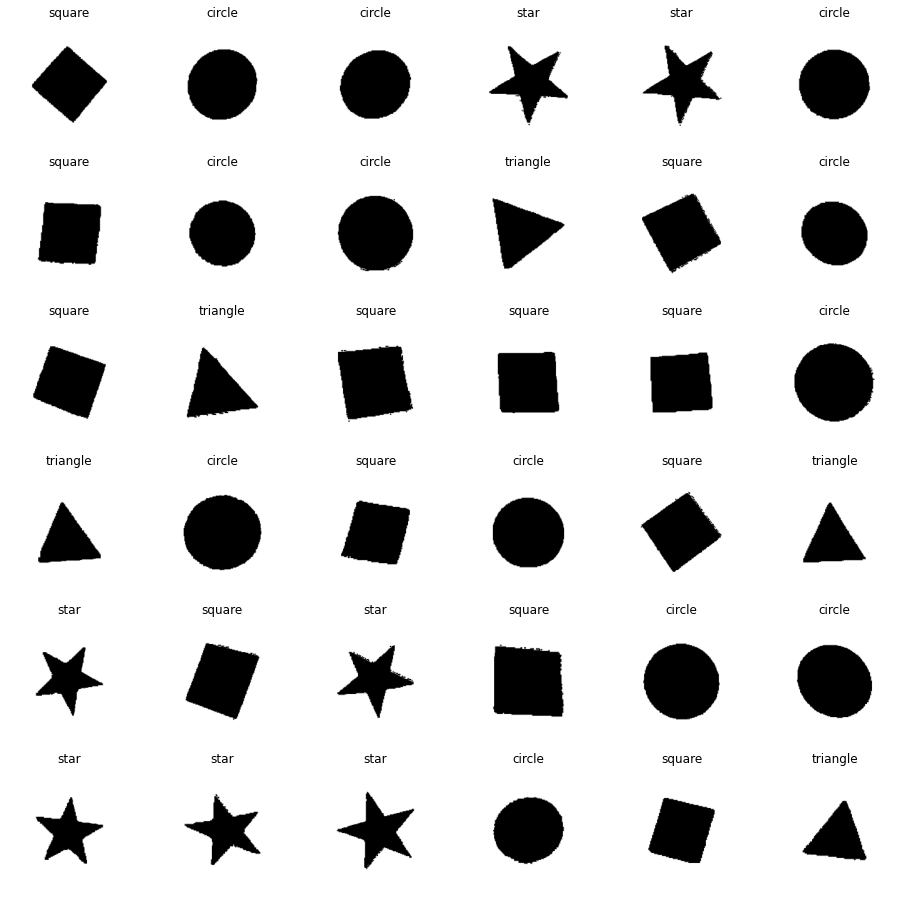

In [6]:
plt.figure(figsize=(16,16))

for i in range(36):
    plt.subplot(6,6,i+1)
    img = cv2.imread(data.path[i])
    plt.imshow(img)
    plt.title(data.iloc[i,1:].sort_values().index[1])
    plt.axis('off')

In [7]:
train, test = train_test_split(data, test_size=.3, random_state=42)

train.shape, test.shape

((10479, 5), (4491, 5))

Found 1 validated image filenames.


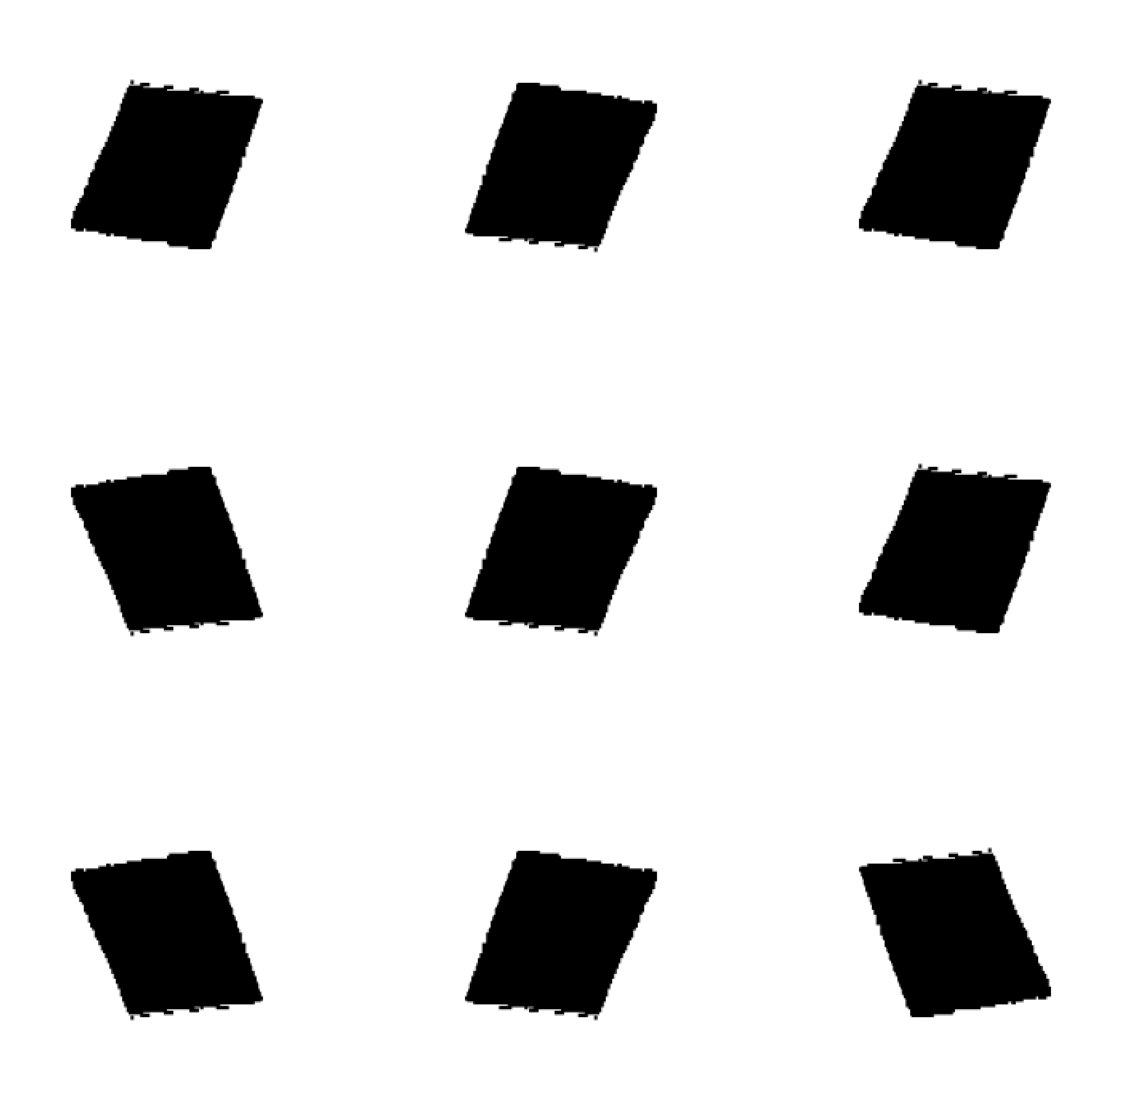

In [8]:
example = train.sample(n=1).reset_index(drop=True)
example_data_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

example_gen = example_data_gen.flow_from_dataframe(example,
                                                  target_size=(200,200),
                                                  x_col="path",
                                                  y_col=['circle', 'square', 'star','triangle'],
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=32)

plt.figure(figsize=(20, 20))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, _ in example_gen:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break

In [9]:
test_data_gen= ImageDataGenerator(rescale=1./255)

train_data_gen= ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

In [10]:
train_generator=train_data_gen.flow_from_dataframe(train,
                                                      target_size=(200,200),
                                                      x_col="path",
                                                      y_col=['circle','square', 'star','triangle'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=32)

Found 10479 validated image filenames.


In [11]:
test_generator=test_data_gen.flow_from_dataframe(test,
                                                  target_size=(200,200),
                                                  x_col="path",
                                                  y_col=['circle', 'square','star','triangle'],
                                                  class_mode='raw',
                                                  shuffle=False,
                                                  batch_size=1)

Found 4491 validated image filenames.


In [14]:
def get_model():
    base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(200, 200, 3))
    x = base_model.output
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
model = get_model()
model.fit_generator(train_generator,
                    epochs=1,
                    steps_per_epoch=train_generator.n/32,
                    )

 33/327 [==>...........................] - ETA: 31:25 - loss: 12.6281 - accuracy: 0.8330

In [ ]:
model.evaluate(test_generator)

In [ ]:
pred_test = np.argmax(model.predict(test_generator, verbose=1), axis=1)

In [ ]:
plt.figure(figsize=(24,24))

for i in range(100):
    plt.subplot(10,10,i+1)
    img = cv2.imread(test.reset_index(drop=True).path[i])
    plt.imshow(img)
    plt.title(test.reset_index(drop=True).iloc[0,1:].index[pred_test[i]])
    plt.axis('off')